# Step 1. Preprocess Unstructured Data

##### Goal
- Turn unstructured data into a format that is ready for EDA and ML models

##### Challenges
- Non-standardized property features
- Sparse features/missing values

##### Approach
- From unstructured data extract most commonly reported housing feature categories
- Drop housing features where over 90% of values are missing

# Load Modules

In [2]:
import pandas as pd
import numpy as np
import math
import ast
import re
import pickle

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
raw_data = pd.read_csv('../data/redfin_cleaned.csv')
raw_data.Price = raw_data.Price.values/10**3
df = pd.read_csv('../data/redfin.csv')
df.shape
df.head()
df = df.rename(columns={'baths':'Baths', 
                   'beds':'Beds', 
                   'price': 'Price', 
                   'sqft':'SqFt',
                   'street':'Address',
                   'zipcode':'Zip'})

Drop observations where price is a Redfin estimate. Only retain sale price.

In [8]:
redfin_est_index = list()
for idx, price in enumerate(df.Price.values):
    if re.findall('Redfin Estimate', price):
        redfin_est_index.append(idx)
df.drop(redfin_est_index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

# 1.1 Main Property Features
- Price
- Beds
- SqFt
- Baths
- Address
- City
- Zip

In [9]:
# Stats details 
index = range(0, df.shape[0])
stats_df = pd.DataFrame(index = index, columns = ['Price',
                                                  'Beds',
                                                  'SqFt', 
                                                  'Baths',
                                                  'Address'])
# Convert strings to integers and remove commas
for column in stats_df.columns.drop('Address'):
    data = [''.join(re.findall(r'[0-9.]', str(i))) for i in df[column]]
    stats_df[column] = data
stats_df['Address'] = df['Address'].values

# Convert address into zip code and city
for count, zipcode in enumerate(df.Zip):
    
    """
    Code clean ups city names (capitalize and remove punctuations)
    and extracts zip codes
    """
    
    if len(zipcode.split(','))==2:
        zipcode = re.sub(' - Century City','',zipcode)
        zipcode = re.sub('County -','',zipcode)
        city_name = [i.capitalize() for i in word_tokenize(zipcode.split(',')[0])]
        city_name = ' '.join(city_name)
        stats_df.loc[count, 'City'] = city_name
        stats_df.loc[count, 'Zip'] = ''.join(re.findall('\d', zipcode.split(',')[1]))
    elif zipcode:
        stats_df.loc[count, 'City'] = 'Unknown'
        stats_df.loc[count, 'Zip'] = ''.join(re.findall('\d', zipcode.split(',')[0]))
    else:
        stats_df.loc[count, 'City'] = 'Unknown'
        stats_df.loc[count, 'Zip'] = np.nan
        
stats_df = stats_df[stats_df.Price.notna()]
stats_df

,Price,Beds,SqFt,Baths,Address,City,Zip
0,499900,3,1232,2.5,1443 Sycamore Ave,Tustin,92780
1,417000,2,1104,1.5,485 E 1st St,Tustin,92780
2,770000,4,1445,2,14542 Gylah Ln,Tustin,92780
3,435000,2,1258,2,14802 Newport Ave Unit 2D,Tustin,92780
4,790000,3,1536,2,155 Mountain View Dr,Tustin,92780
...,...,...,...,...,...,...,...
12036,2400000,5,4530,5.5,9691 Villa Woods Dr,Villa Park,92861
12037,1276000,4,3274,2.5,10432 Alma Ln,Villa Park,92861
12038,2175000,5,5219,4.5,9841 Ludwig St,Villa Park,92861
12039,1400000,5,3377,3,9601 Dodson Way,Villa Park,92861


# 1.2 Key  Features

- PropertyType
- YearBuilt
- Community
- LotSize
- RedfinEstimate
- PricePerSqFt


In [10]:
# Key details 
key_df = pd.DataFrame(index = index)

# Convert strings to dictionary
for count, details in enumerate(df['key_details_dict']):
    dict_ = ast.literal_eval(details)
    for key, value in dict_.items():
        key = re.sub(r"[/]", 'Per', key)
        key = re.sub(r"[#\. ']", '', key)
        key_df.loc[count, key] = value
        
# Drop redundant columns and non-essential housing features
drop_columns = ['BuyersBrokerageCommission', 'Style', 'Status', 'MLS','HOADues', 'Baths']
key_df.drop(drop_columns, axis=1, inplace=True)

# Clean up numerical columns, "Lot Size" and "Baths" require special adjustment
columns = key_df.columns.drop(['PropertyType','LotSize', 'Community'])
for column in columns:
    data = key_df[column].replace('/month','')
    data = [''.join(re.findall(r'[0-9.]', str(i))) for i in data]
    key_df[column] = data
    key_df[column].replace('', np.nan)
key_df

,PropertyType,YearBuilt,Community,LotSize,RedfinEstimate,PricePerSqFt
0,Condominium,1964,71 - Tustin,"1,646 Sq. Ft.",535330,406
1,Condominium,1964,71 - Tustin,NaN,464222,378
2,Single Family Residence,1963,71 - Tustin,0.27 Acres,833905,533
3,Condominium,1965,71 - Tustin,NaN,453265,346
4,Single Family Residence,1924,71 - Tustin,0.29 Acres,978939,514
...,...,...,...,...,...,...
12036,Single Family Residence,1970,73 - Villa Park,0.44 Acres,2369106,530
12037,Single Family Residence,1975,73 - Villa Park,0.48 Acres,1335412,390
12038,Single Family Residence,1974,73 - Villa Park,0.47 Acres,2268368,417
12039,Single Family Residence,1961,73 - Villa Park,0.55 Acres,1497148,415


# 1.3 Property Interior, Exterior, Lot, and Community Features

- Convert acres into sqft
- Aggregate property types into single family residence, condos, and townhomes
- Extract most commonly reported property features

In [11]:
# Helper function: acreage to sqft converter 
def convert_acre_to_sqft(lot, text):
    if lot[1].find('Acre')>-1:
        text = round(text * 43560)
    return text
            
# Convert acre to sqft
for count, lot in enumerate(key_df['LotSize']):
    if str(lot) != 'nan':
        lot = str(lot)
        lot = lot.split(' ')
        text = re.findall(r'\b[0-9,.]+\b', lot[0])
        text = ''.join(text)
        text = text.replace(',','')
        text = float(text)
        text = convert_acre_to_sqft(lot, text)
        key_df.loc[count, 'LotSize'] = text

In [12]:
for column in key_df.columns:
    key_df[column] = pd.to_numeric(key_df[column], errors = 'ignore')
num_cols = key_df.select_dtypes(exclude='object').columns
categ_cols = key_df.columns.drop(num_cols)
key_df.PropertyType = [''.join(re.findall("[A-Za-z0-9/\- ]", str(i).lstrip())) for i in key_df.PropertyType]
sorted(key_df.PropertyType.unique())

['All Other Attached',
 'Apartment/Condo',
 'Commercial/Residential',
 'Condo/Co-op',
 'Condominium',
 'Condominium Residential Condo/Co-Op',
 'Detached',
 'Duplex',
 'Quadruplex',
 'Residential Single-Family',
 'Single Family Detached',
 'Single Family Home',
 'Single Family Residence',
 'Single Family Residential',
 'Single Family Residential Single-Family',
 'Townhome',
 'Townhouse',
 'Townhouse Residential Condo/Co-Op',
 'Townhouse Residential Single-Family',
 'Triplex',
 'nan']

In [13]:
# Property Type
PropertyType_dict = {'nan':None,
                     'Quadruplex':'Condominium',
                     'All Other Attached':'Condominium',
                     'Duplex':'Condominium',
                     'Single Family Residential Single-Family':'Single Family Residence',
                     'Townhouse Residential Condo/Co-Op':'Townhouse',
                     'Condominium Residential Condo/Co-Op':'Condominium',
                     'Residential Single-Family':'Single Family Residence',
                     'Apartment/Condo':'Condominium', 
                     'Townhome':'Townhouse',
                     'Condo/Co-op':'Condominium',
                     'Townhouse Residential Single-Family':'Single Family Residence',
                     'Single Family Detached':'Single Family Residence',
                     'Detached':'Single Family Residence',
                     'Single Family Home':'Single Family Residence', 
                     'Triplex':'Condominium',
                     'Single Family Residential':'Single Family Residence'}
key_df['PropertyType'].replace(PropertyType_dict, inplace=True)
key_df = key_df.loc[key_df.PropertyType!='Commercial/Residential']

In [14]:
prop_df = pd.DataFrame(index=index)
replace_dict = {'1/2':'Half', '1/4':'Quarter', '3/4':'ThreeQuarters'}
for count, prop in enumerate(df['property_details_dict']):
    dict_ = ast.literal_eval(prop)    
    for key, value in dict_.items():
        
        # Latitude
        if re.findall(r'\bLatitude\b', str(key)):
            prop_df.loc[count, 'Latitude'] = value
            
        # Longitude
        if re.findall(r'\bLongitude\b', str(key)):
            prop_df.loc[count, 'Longitude'] = value  
        
        # Levels
        if re.match(r'\bLevels?\b', key):
            if re.findall('Multi/Split', str(value)):
                prop_df.loc[count, 'Levels'] = 'Multi/Split'
            elif re.findall('Three Or More', str(value)):
                prop_df.loc[count, 'Levels'] = 'Three Or More'
            elif re.findall('Two', str(value)):
                prop_df.loc[count, 'Levels'] = 'Two'
            elif re.findall('One', str(value)) or re.findall('1', str(value)):
                prop_df.loc[count, 'Levels'] = 'One'
        elif re.findall(r'\bMulti/Split\b',key):
            prop_df.loc[count, 'Levels']='Multi/Split'
        elif re.findall(r'\bThree Or More Levels?\b',key):
            prop_df.loc[count, 'Levels']='Three Or More'
        elif re.findall(r'\bTwo Levels?\b',key):
            prop_df.loc[count, 'Levels']='Two'
        elif re.findall(r'\bOne Levels?\b',key):
            prop_df.loc[count, 'Levels']='One'
            
        # Garage
        if re.findall('# of Garage', key):
            prop_df.loc[count, 'GarageSpaces']=value
        elif re.findall('4+ Car Garage', key):
            prop_df.loc[count, 'GarageSpaces']=4
        elif re.findall('3 Car Garage', key):
            prop_df.loc[count, 'GarageSpaces']=3
        elif re.findall('2 Car Garage', key):
            prop_df.loc[count, 'GarageSpaces']=2
        elif re.findall('Garage', key):
            prop_df.loc[count, 'GarageSpaces']=1
        
        # Common Walls
        if re.findall(r'\bCommon Walls\b', key):
            if re.findall('2+', str(value)):
                prop_df.loc[count, 'CommonWalls']='2+ Common Walls'
            elif re.findall('1', str(value)):
                prop_df.loc[count, 'CommonWalls']='1 Common Wall'
            elif re.findall('No Common Wall', str(value)):
                prop_df.loc[count, 'CommonWalls']='No Common Wall'
                
        # Parking
        if re.findall('#.*Parking', key):
            key = re.sub('#.*Parking.*', 'ParkingSpaces',key)
            prop_df.loc[count, key.strip()]=value
            
        # Spa
        if re.findall('Spa Features', key) or re.findall('Spa.*Description', key) or re.findall('Spa.*Construction', key):
            for sub_key in word_tokenize(value):
                if re.match('Private', str(sub_key)):
                    prop_df.loc[count, 'Spa'] = 'Private'
                elif re.match('Community', str(sub_key)) or re.match('Association', str(sub_key)):
                    prop_df.loc[count, 'Spa'] = 'Community'
        elif re.findall(r'\bSpa\b', key):
            for sub_key in word_tokenize(key):
                if re.match('Private', str(sub_key)):
                    prop_df.loc[count, 'Spa'] = 'Private'
                elif re.match('Community', str(sub_key)) or re.match('Association', str(sub_key)):
                    prop_df.loc[count, 'Spa'] = 'Community'
                    
        # Pool
        if re.findall('Pool Features', key) or re.findall('Pool.*Description', key) or re.findall('Pool.*Construction', key):
            for sub_key in word_tokenize(value):
                if re.match('Private', str(sub_key)):
                    prop_df.loc[count, 'Pool'] = 'Private'
                elif re.match('Community', str(sub_key)) or re.match('Association', str(sub_key)):
                    prop_df.loc[count, 'Pool'] = 'Community'
        elif re.findall(r'\bPool\b', key):
            for sub_key in word_tokenize(key):
                if re.match('Private', str(sub_key)):
                    prop_df.loc[count, 'Pool'] = 'Private'
                elif re.match('Community', str(sub_key)) or re.match('Association', str(sub_key)):
                    prop_df.loc[count, 'Pool'] = 'Community'
        
        # Kitchen Island
        if re.findall(r'\bKitchen Island\b', key):
            prop_df.loc[count, 'KitchenIsland'] = 'Yes'
                    
        # Patio
        if re.findall(r'\bPatio\b', key):
            prop_df.loc[count, 'Patio'] = 'Yes'
            
        # Main Level Bathrooms
        if re.findall(r'\bMain Level Bathrooms\b', key):
            prop_df.loc[count, 'MainLevelBathrooms']=value
             
        # Main Level Bedrooms
        if re.findall(r'\bMain Level Bedrooms\b', key):
            prop_df.loc[count, 'MainLevelBedrooms']=value
            
        # Walk-In Closet
        if re.findall(r'\bWalk.*Closets?\b', key):
            prop_df.loc[count, 'WalkInCloset'] = 'Yes'
            
        # High Ceiling/Cathedral
        if re.findall(r'\bCathedral\b', key) or re.findall(r'\bHigh Ceiling\b', key):
            prop_df.loc[count, 'HighCeiling'] = 'Yes'
            
        # Fire Place
        if re.findall(r'\bFireplace\b', key):
            prop_df.loc[count, 'Fireplace'] = 'Yes'
            
        # Central Air/Heating/Cooling
        if re.findall(r'\bCentral\b', key) and not (re.findall(r'\bCentral Vacuum\b', str(key)) or re.findall(r'\bVacuum Central\b', str(key))):
            prop_df.loc[count, 'CentralAir'] = 'Yes'
            
        # Outdoors (Hiking, Biking)
        if re.findall(r'\bHiking\b|\bBiking\b', key):
            prop_df.loc[count, 'CloseToOutdoors'] = 'Yes'
        elif re.findall(r'\bHiking\b|\bBiking\b', str(value)):
            prop_df.loc[count, 'CloseToOutdoors'] = 'Yes'

In [15]:
# Convert missing housing features to 'No' category
for col in prop_df.columns.drop(['MainLevelBathrooms','MainLevelBedrooms',
                                 'Latitude','Longitude',
                                 'Levels','CommonWalls']):
    prop_df[col] = pd.to_numeric(prop_df[col], errors='ignore')
    if prop_df[col].dtypes != 'object':
        prop_df[col] = prop_df[col].fillna(0)
    else:
        prop_df[col] = ['No' if str(i)=='nan' else i for i in prop_df[col]]

# 1.4 School District
- Grade
- Rating
- Distance
- Public/Private (or Charter)

In [16]:
# Get School Details Attributes
list_= set()
school_df = pd.DataFrame(index = index)
for count, school in enumerate(df['school_details_dict']):
    dict_ = ast.literal_eval(school)
    for key, value in dict_.items():
        name, rating, school_type, school_dist = [i for i in value]
        if rating:
            column = key + '_rating'
            school_df.loc[count, column] = rating.replace('NR','')
        if school_type:
            column = key + '_type'
            school_df.loc[count, column] = school_type.replace('NR','')
        if school_dist:
            column = key + '_dist'
            school_df.loc[count, column] = school_dist.replace('NR','').replace('mi','').strip()

In [17]:
# Get School Details Attributes
school_grade_dict = {'12':'Twelve',
                     '11':'Eleven',
                     '10':'Ten',
                     '1':'One',
                     '2':'Two',
                     '3':'Three', 
                     '4':'Four', 
                     '5':'Five', 
                     '6':'Six', 
                     '7':'Seven',
                     '8':'Eight', 
                     '9':'Nine'}
school_df = pd.DataFrame(index = index)
for count, school in enumerate(df['school_details_dict']):
    dict_ = ast.literal_eval(school)
    for key, value in dict_.items():
        for grade, new_grade in school_grade_dict.items():
            key = key.replace(grade, new_grade)
            key = key.replace(' ','')
        name, rating, school_type, school_dist = [i for i in value]
        if rating:
            column = key + 'Rating'
            school_df.loc[count, column] = rating.replace('NR','')
        if school_type:
            column = key + 'Type'
            school_df.loc[count, column] = school_type.replace('NR','')
        if school_dist:
            column = key + 'Dist'
            school_df.loc[count, column] = school_dist.replace('NR','').replace(' mi','')
school_df.columns

# Check missing
for col in school_df.columns:
    percent_missing = np.sum(school_df[col].isna())/len(school_df[col])
    if percent_missing>0.90:
        print('Dropped Column:', col, '\n',
              'Percent Missing:', round(percent_missing * 100,  2))
        school_df = school_df.drop(col, axis=1)

Dropped Column: PreschooltoFiveRating 
 Percent Missing: 95.16
Dropped Column: PreschooltoFiveType 
 Percent Missing: 95.16
Dropped Column: PreschooltoFiveDist 
 Percent Missing: 95.16
Dropped Column: PreschooltoSixRating 
 Percent Missing: 93.61
Dropped Column: PreschooltoSixType 
 Percent Missing: 93.61
Dropped Column: PreschooltoSixDist 
 Percent Missing: 93.61
Dropped Column: SeventoTwelveRating 
 Percent Missing: 95.17
Dropped Column: SeventoTwelveType 
 Percent Missing: 95.17
Dropped Column: SeventoTwelveDist 
 Percent Missing: 95.17
Dropped Column: PreschooltoTwoRating 
 Percent Missing: 99.0
Dropped Column: PreschooltoTwoType 
 Percent Missing: 99.0
Dropped Column: PreschooltoTwoDist 
 Percent Missing: 99.0
Dropped Column: ThreetoSixRating 
 Percent Missing: 99.0
Dropped Column: ThreetoSixType 
 Percent Missing: 99.0
Dropped Column: ThreetoSixDist 
 Percent Missing: 99.0
Dropped Column: KtoEightRating 
 Percent Missing: 93.4
Dropped Column: KtoEightType 
 Percent Missing: 93.4


# 1.5 Neighborhood Attributes
- Bike Score
- Transit Score
- Walkability Score

In [18]:
# Scores
scores_df = pd.DataFrame(index = index)
for count, score in enumerate(df['scores_dict']):
    dict_  = ast.literal_eval(score)
    for key, value in dict_.items():
        key = [str(i).capitalize() for i in str(key).split('_')]
        key = ''.join(key)
        if value != None:
            scores_df.loc[count, key] = value
        else:
            value = np.nan
scores_df.drop('CompetitiveScore', axis=1, inplace=True)

In [19]:
# Merge data
data = stats_df.merge(key_df, left_index = True, right_index=True, how='inner')
data = data.merge(prop_df, left_index = True, right_index=True, how='inner')
data = data.merge(school_df, left_index = True, right_index=True, how='inner')
data = data.merge(scores_df, left_index = True, right_index=True, how='inner')
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='ignore')

In [20]:
# Save
data.to_csv('../data/redfin_cleaned.csv', index=False)

# Step 2. Exploratory Data Analysis

##### Goal
- Uncover relationships between sale price and property features that will improve ML performance
- Identify outliers
- Explore spatial distribution of sale price

In [38]:
raw_data = pd.read_csv('../data/redfin_cleaned.csv')
data = raw_data.copy()
data = data.loc[data.Price.notna()]
data = data.loc[data.Zip.notna()]
data['Price'] = data['Price'].values/10**3
data = data.loc[(data.Longitude.notna()) & (data.Longitude.values!=0)]
data['Zip'] = data.Zip.astype('int64')
data.shape

(11873, 48)

In [39]:
drop_cols = ['Address',
             'KtoFiveType',
             'KtoSixType',
             'NinetoTwelveType',
             'SeventoEightType',
             'SixtoEightType',
             'SixtoEightRating',
             'SixtoEightDist',
             'KtoSixRating',
             'KtoSixDist',
             'SeventoEightRating',
             'SeventoEightDist',
             'KtoFiveRating',
             'KtoFiveDist',
             'Community',
             'RedfinEstimate',
             'PricePerSqFt']
data.drop(drop_cols, axis=1, inplace=True)
data.columns.values

array(['Price', 'Beds', 'SqFt', 'Baths', 'City', 'Zip', 'PropertyType',
       'YearBuilt', 'LotSize', 'CentralAir', 'Fireplace', 'Levels',
       'MainLevelBathrooms', 'MainLevelBedrooms', 'Spa', 'GarageSpaces',
       'ParkingSpaces', 'Patio', 'Pool', 'CommonWalls', 'Latitude',
       'Longitude', 'WalkInCloset', 'KitchenIsland', 'CloseToOutdoors',
       'HighCeiling', 'NinetoTwelveRating', 'NinetoTwelveDist',
       'WalkScore', 'TransitScore', 'BikeScore'], dtype=object)

In [40]:
zip_list = data['Zip'].value_counts().to_frame()
zip_list['ZipCount'] = zip_list['Zip']
zip_list['Zip'] = zip_list.index
zip_list

data = data.merge(zip_list, on='Zip')
data = data.loc[data['ZipCount']>100]
data.drop('ZipCount', axis=1, inplace=True)
data.shape

(10302, 31)

In [41]:
cols = ['Price', 'SqFt', 'LotSize',
        'GarageSpaces','ParkingSpaces',
        'MainLevelBathrooms','MainLevelBedrooms',
        'BikeScore','TransitScore', 'WalkScore']
outlier_data = pd.DataFrame(index=data.index)

for col in cols:
    std = (data[col].values - data[col].mean())/data[col].std()
    outlier_data[col] = std
outlier_index = outlier_data.index[(np.abs(outlier_data)>3).any(axis=1)]

data = data.drop(outlier_index, axis=0)

idx = data.index[data['LotSize']>0.3 * 1e6].values
data.drop(index=idx, inplace=True)

idx = data.index[data['ParkingSpaces']>10].values
data.drop(index=idx, inplace=True)

# Prepare data for EDA
- First split data into training and test sets to prevent data leakage
- Then perform EDA (check missingness, skewness, correaltions)

In [42]:
rng = np.random.RandomState(17)
test_size = 0.2
data_train, data_test = train_test_split(data, random_state=rng, test_size=test_size)

# Check distribution of main property features

<AxesSubplot:xlabel='Baths', ylabel='Proportion'>

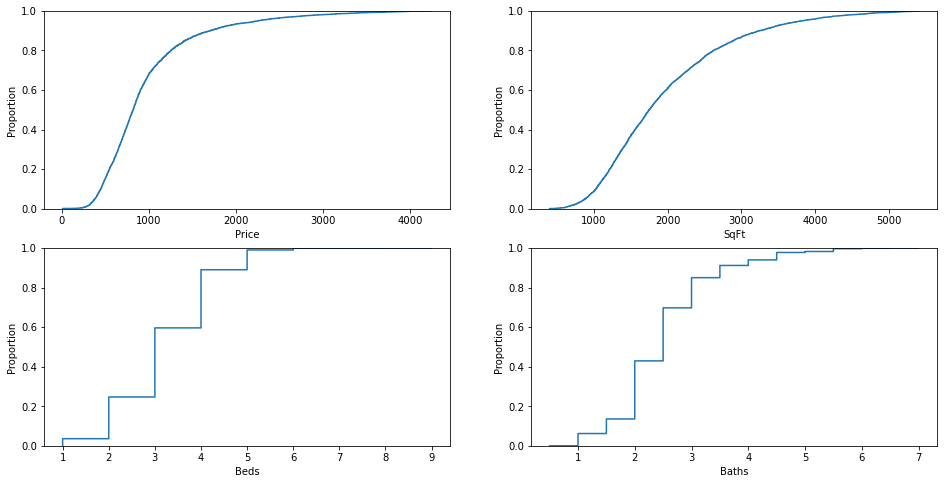

In [43]:
f, ax = plt.subplots(2,2,figsize=(16,8))
sns.ecdfplot(data_train, x="Price", ax=ax[0,0])
sns.ecdfplot(data_train, x="SqFt", ax=ax[0,1])
sns.ecdfplot(data_train, x="Beds", ax=ax[1,0])
sns.ecdfplot(data_train, x="Baths", ax=ax[1,1])

# Plot spatial distribution of sale price

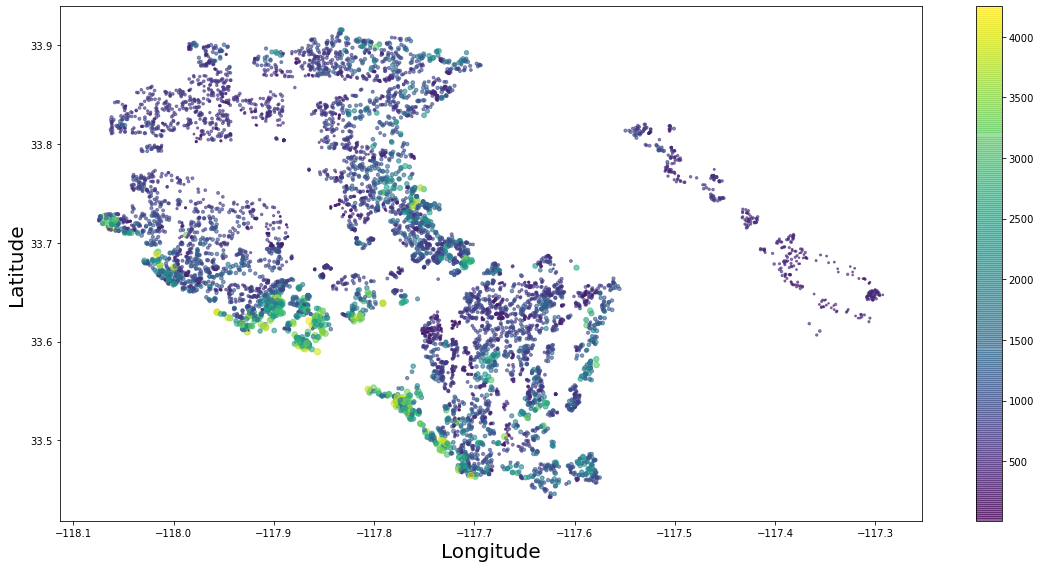

In [84]:
fig, ax = plt.subplots(figsize=(16,8))
data_train.plot(kind="scatter", 
              x="Longitude", y="Latitude", 
              alpha=0.6,
              c=data_train['Price'], 
              s=data_train['Price']/10**2,
              cmap=plt.get_cmap("viridis"), colorbar=True,
              ax=ax
)
#plt.title('Sale Price (Thousands) in Last Six Months',  fontsize=30)
plt.xlabel('Longitude',fontsize=20)
plt.ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.savefig('../output/fig_map.pdf')

# Mean sale price by city

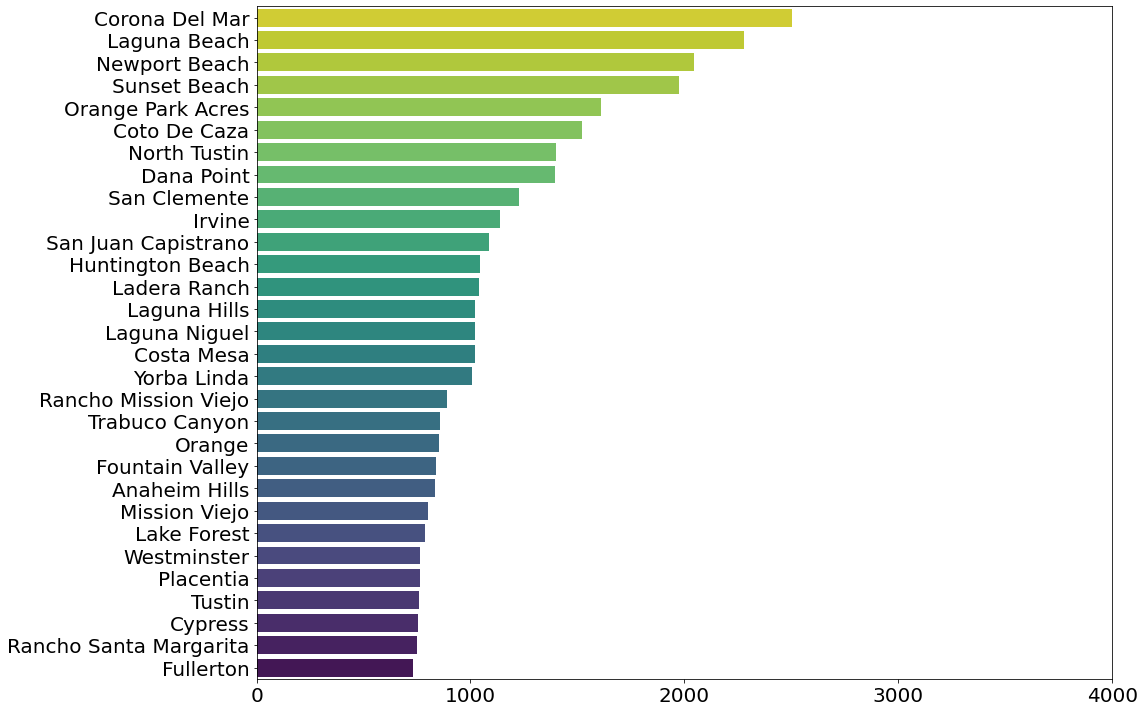

In [83]:
price_by_city = data_train.groupby('City').agg({'Price':'mean'},{'City':'first'})
price_by_city.sort_values('Price', inplace=True, ascending=False)
price_by_city = price_by_city.iloc[0:30,]
price_by_city.reset_index(inplace=True)
f, ax = plt.subplots(figsize=(16, 10))
sns.barplot(y = 'City', x='Price', data=price_by_city, palette='viridis_r')
#ax.set_title('Mean Sale Price (Thousands) in Last Six Months', fontsize=30)
ax.set_ylabel('')
ax.set_yticks(np.arange(0, len(price_by_city['City'])))
ax.set_yticklabels(price_by_city['City'], fontsize=20)
ax.set_xlabel('')
ax.set_xticks(np.arange(0,5000,1000))
ax.set_xticklabels(np.arange(0,5000,1000), fontsize=20)
f.tight_layout()
f.savefig('../output/fig_CitySalePrice.pdf')

# Mean sale price by property type

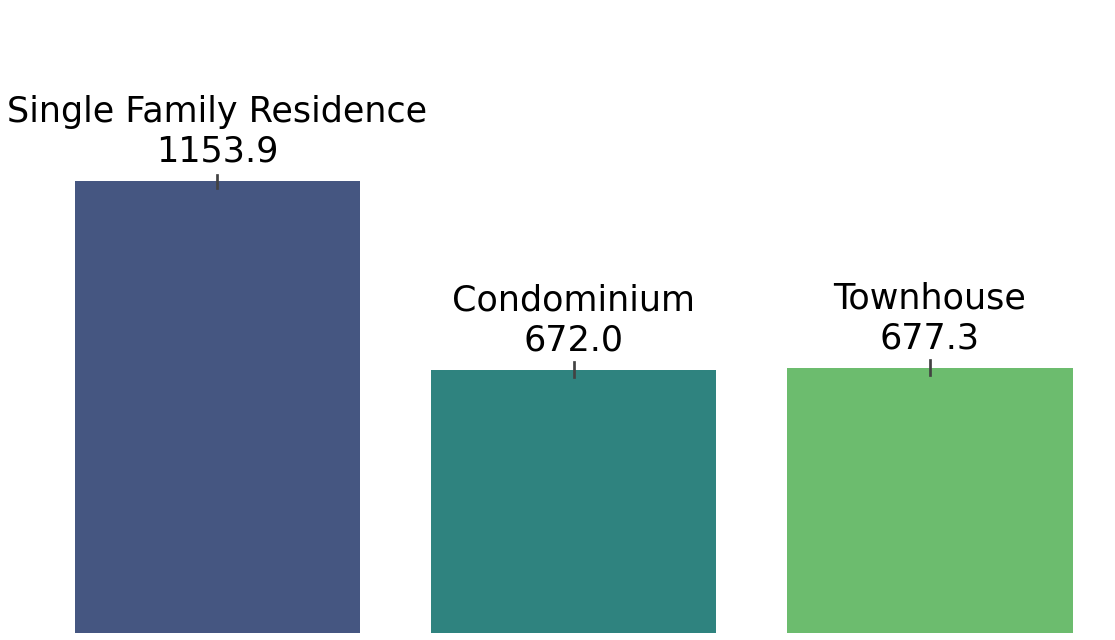

In [88]:
f, ax = plt.subplots(figsize=(16, 9))
sns.barplot(x='PropertyType', y='Price', data=data_train, palette='viridis')
#ax.set_title('Mean Sale Price (Thousands) in Last Six Months', fontsize=30)
ax.axis('off')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('')
ax.set_yticks(np.arange(0,1800,200))
ax.set_yticklabels('')
for a,b in zip(data_train.PropertyType.dropna().unique(), ax.patches):
    ax.annotate(a + '\n' + format(b.get_height(), '.1f'), 
                (b.get_x() + b.get_width() / 2., b.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 50), fontsize=35,
                textcoords = 'offset points')
f.tight_layout()
f.savefig('../output/fig_PropTypeSalePrice.pdf')

# Relationship between sale price and sqft linear appears roughly linear

<ipython-input-82-87e254562014>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0,8000,100), fontsize=20)
<ipython-input-82-87e254562014>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0,3000,500), fontsize=20)


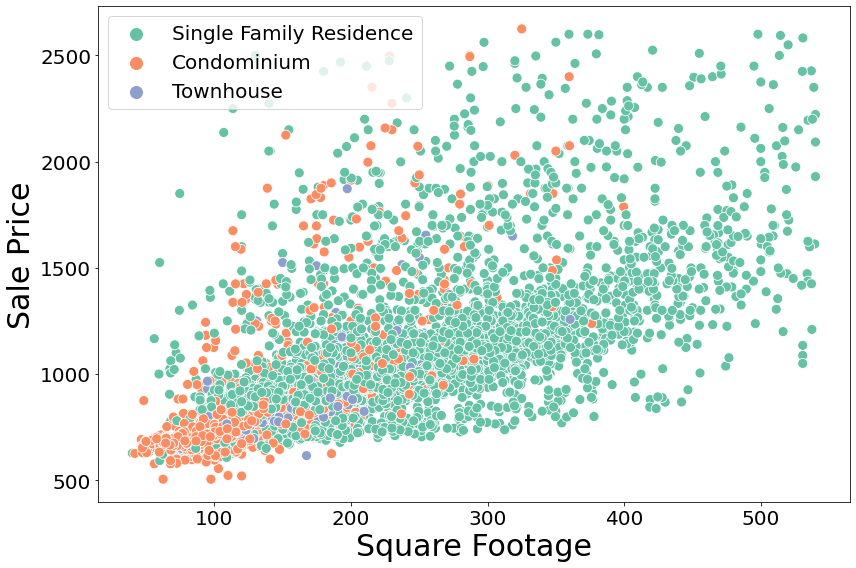

In [82]:
f, ax = plt.subplots(figsize = (12,8))
sns.scatterplot(x='SqFt', y = 'Price', 
                hue="PropertyType", palette='Set2',
                s=100,
                data=data_train)
#ax.set_title('Sale Price (Thousands) and Square Footage', fontsize=30)
ax.set_xticklabels(np.arange(0,8000,100), fontsize=20)
ax.set_yticklabels(np.arange(0,3000,500), fontsize=20)
ax.set_xlabel("Square Footage",fontsize=30)
ax.set_ylabel("Sale Price",fontsize=30)
ax.legend(markerscale=2,fontsize=20)
f.tight_layout()
f.savefig('../output/fig_scatterplot.pdf')

# Relationship between sale price and # of beds and baths are also linear

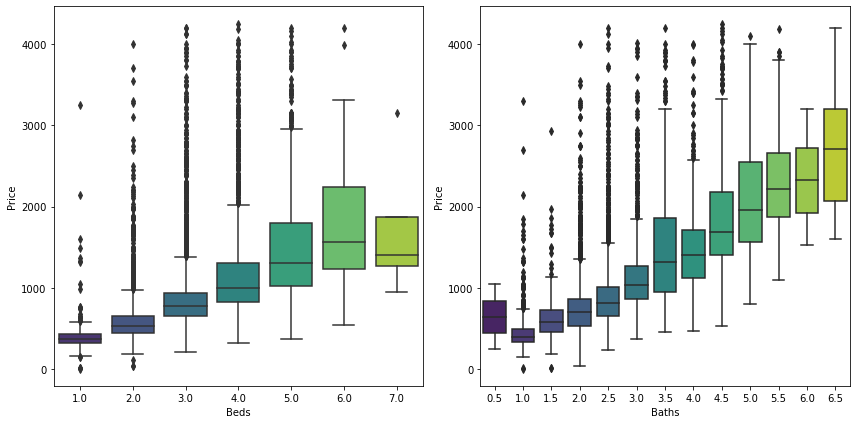

In [77]:
f, ax = plt.subplots(1,2, figsize=(12, 6))
sns.boxplot(x ='Beds', y ='Price', 
            data = data_train[data_train.Beds<9], 
            ax=ax[0], 
            palette='viridis')
sns.boxplot(x ='Baths', y ='Price', 
            data = data_train[data_train.Baths<7], 
            ax=ax[1], 
            palette='viridis')
f.tight_layout()
f.savefig('../output/fig_boxplot.pdf')

# Heatmap of pairwise correlations

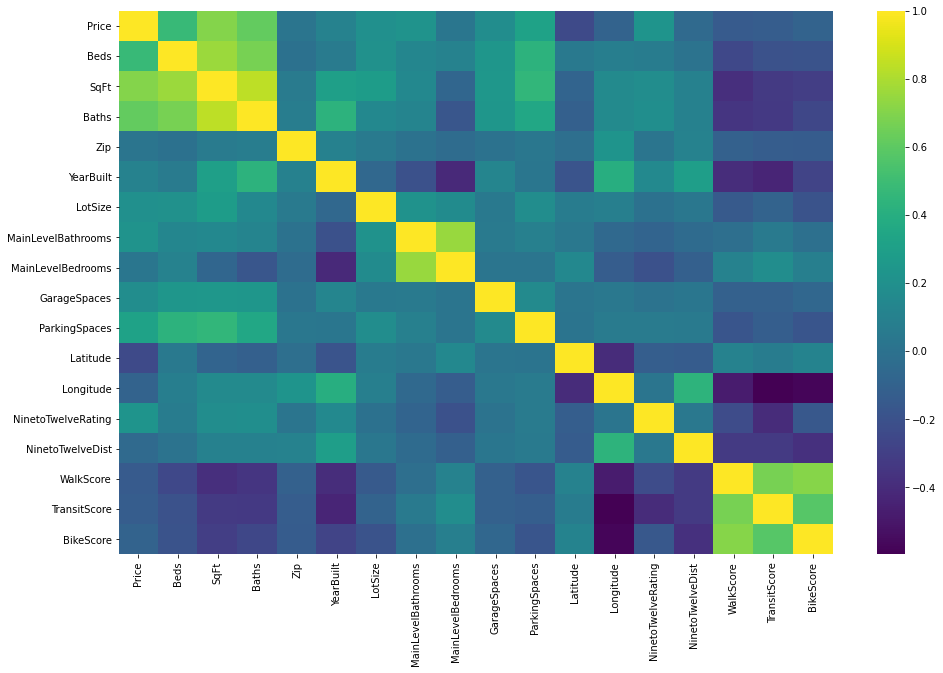

In [65]:
f, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(data_train.corr(), cmap='viridis')
f.savefig('../output/fig_heatmap.pdf')